In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from scipy import stats

import math

from datetime import datetime

In [2]:
# load the data
data = pd.read_csv('btc_ta.csv')

In [3]:
# examine the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638440 entries, 0 to 2638439
Data columns (total 74 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   time                       int64  
 2   open                       float64
 3   close                      float64
 4   high                       float64
 5   low                        float64
 6   volume                     float64
 7   volume_adi                 float64
 8   volume_obv                 float64
 9   volume_cmf                 float64
 10  volume_fi                  float64
 11  volume_em                  float64
 12  volume_sma_em              float64
 13  volume_vpt                 float64
 14  volume_nvi                 float64
 15  volatility_atr             float64
 16  volatility_bbm             float64
 17  volatility_bbh             float64
 18  volatility_bbl             float64
 19  volatility_bbw             float64
 20  vo

In [4]:
# create the target feature
data['nextClosingPrice'] = data['close'].shift(-1)

# drop the rows with 'None' in target column
data = data.dropna(subset=['nextClosingPrice'])
data = data.drop(['trend_psar_down', 'trend_psar_up'], axis=1)

# drop na values from feature extraction
data = data.dropna()

In [5]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

In [6]:
def testModel(df, windowLength, startingIndex, endingIndex, stepSize, modelName):

    # lists to store data, will concat to make result data frame
    rmseList = []
    predList = []
    realList = []
    predTimeList = []
    
    # extract feature and test data
    X = df.drop(['Unnamed: 0', 'time', 'nextClosingPrice'], axis=1)
    y = df['nextClosingPrice']

    # rolling window test
    for i in range(startingIndex, endingIndex, stepSize):
        
        # split the data
        X_train, X_test = X[i-windowLength:i], X[i:i+1]
        y_train, y_test = y[i-windowLength:i], y[i]
        
        # create a new model
        if modelName == 'dt':
            model = DecisionTreeRegressor()
        elif modelName == 'xgb':
            model = XGBRegressor()
        elif modelName == 'lgbm':
            model = LGBMRegressor()
        elif modelName == 'lr':
            model = LinearRegression()
        elif modelName == 'ridge':
            model = Ridge(alpha=0.01)
        elif modelName == 'svr':
            model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
        
        # train the model
        model.fit(X_train, y_train)

        # make a prediction
        y_pred = model.predict(X_test)
        
        # record time figures for result data frame
        predTimeList.append(df['time'][i])
        predList.append(y_pred)
        realList.append(y_test)
        
        # measure the error of this prediction
        squared_error = (y_test - y_pred) **2
        root_squared_error = math.sqrt(squared_error)
        rmseList.append(root_squared_error)
        
    # result dictionary
    predList = [x[0] for x in predList]
    result_data = pd.DataFrame({'Timestamp': predTimeList, "Real": realList, "Preds": predList, 'rmse': rmseList})
    
    # result plot
    plt.plot('Timestamp', 'Real', data=result_data)
    plt.plot('Timestamp', 'Preds', data=result_data)
    plt.legend()
    
    print("")
    print("RMSE mean:{}, std:{}".format(result_data['rmse'].mean(), result_data['rmse'].std()))
    
    return result_data


RMSE mean:3.5338416166666673, std:3.160180679982634


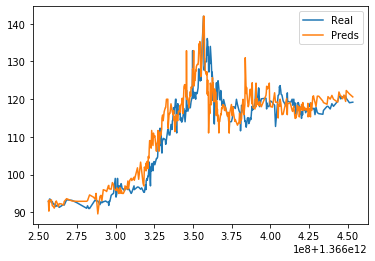

In [7]:
 # test models trained over the previous 360 minutes
dt_results = testModel(data, 360, 9000, 10200, 3, 'dt')


RMSE mean:3.3550561614874947, std:2.9290053133344003


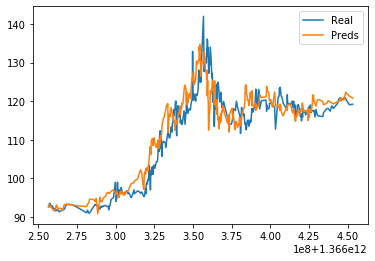

In [8]:
lgbm_results = testModel(data, 360, 9000, 10200, 3, 'lgbm')


RMSE mean:3.4972110056130457, std:3.0991841317446145


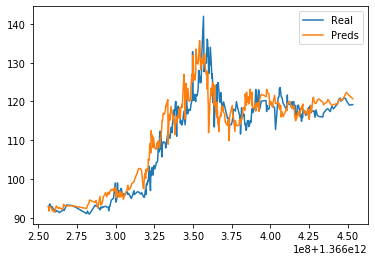

In [9]:
lr_results = testModel(data, 360, 9000, 10200, 3, 'lr')


RMSE mean:3.4566985516479303, std:3.0287998798922957


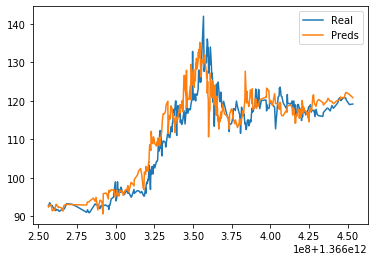

In [10]:
xgb_results = testModel(data, 360, 9000, 10200, 3, 'xgb')

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.06942e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.48807e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.48373e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.48656e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.24665e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.24419e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.24435e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.24572e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.94206e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.92903e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.91887e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.01993e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.45689e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.45714e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.4765e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47637e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.37771e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.37761e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.37777e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.37783e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.33154e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.33152e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.33172e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.3318e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.13936e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.13939e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.13955e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.14018e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.92922e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.93047e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.93098e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.92983e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.3372e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,



RMSE mean:3.490992708890613, std:3.100225850762427


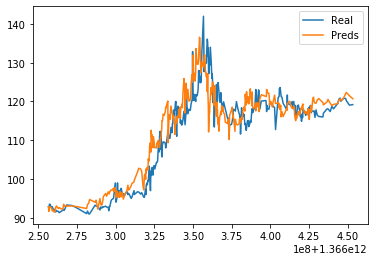

In [11]:
ridge_results = testModel(data, 360, 9000, 10200, 3, 'ridge')


RMSE mean:4.843082166480199, std:4.390728301761778


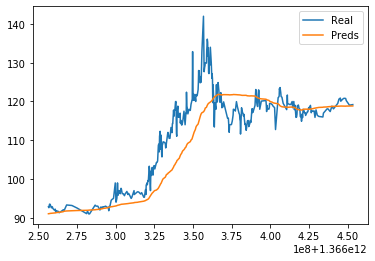

In [12]:
svr_results = testModel(data, 360, 9000, 10200, 3, 'svr')